
===== PERFORMANCE COMPARISON =====
                             Final    Profit  Sharpe  MaxDD  Trades
Period      Strategy                                               
03feb-18feb MACD         992032.00  -7968.00   -0.01  -0.01   16317
            RSI          998932.25  -1067.75   -0.00  -0.01    3718
            Stochastic   995367.50  -4632.50   -0.01  -0.01    1011
            Combined     999608.75   -391.25   -0.00  -0.00    1348
            Buy&Hold    1031855.25  31855.25    0.01  -0.02       1
31mar-15apr MACD        1002442.50   2442.50    0.00  -0.03   15923
            RSI          987211.75 -12788.25   -0.00  -0.03    3971
            Stochastic  1010147.00  10147.00    0.00  -0.02    1267
            Combined    1004937.25   4937.25    0.00  -0.02    1322
            Buy&Hold     975614.00 -24386.00   -0.00  -0.16       1
full-period MACD         956567.00 -43433.00   -0.00  -0.06   69055
            RSI         1016051.50  16051.50    0.00  -0.03   16613
            

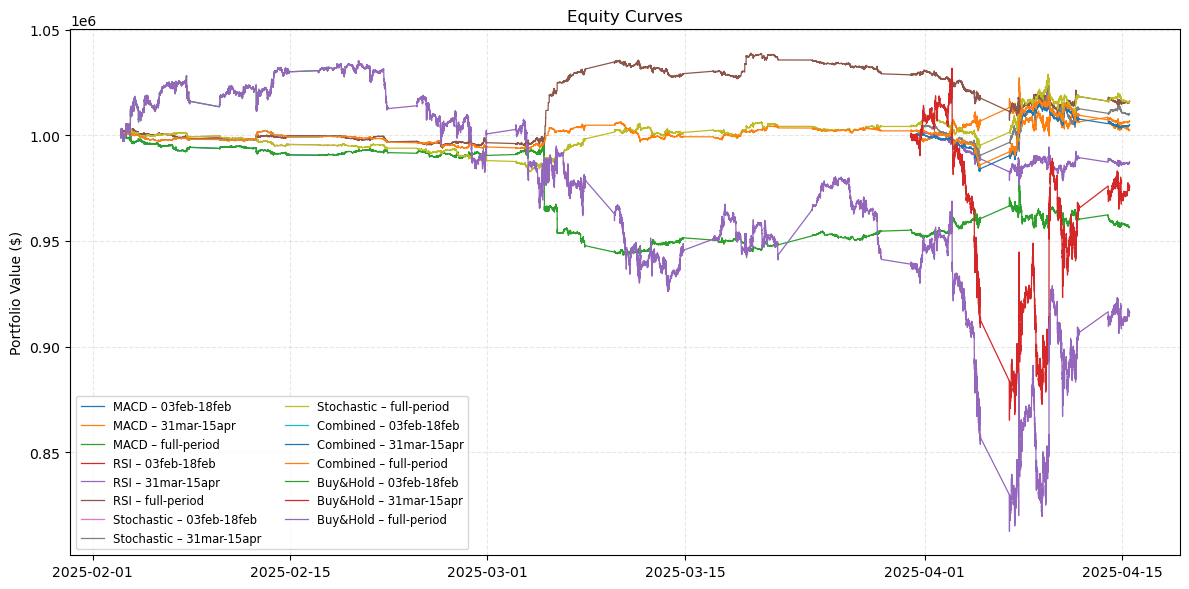

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from typing import Dict

# ─── CONFIG ─────────────────────────────────────────────────────
PERIODS = {
    "03feb-18feb": ("2025-02-03", "2025-02-18"),
    "31mar-15apr": ("2025-03-31", "2025-04-15"),
    "full-period": (None, None),  # unfiltered
}

STRATS: Dict[str, str | None] = {
    "MACD":      "Signal_MACD",
    "RSI":       "Signal_RSI",
    "Stochastic":"Signal_Stoch",
    "Combined":  "Signal_Comb",
    "Buy&Hold":  None,
}

# ─── LOAD AND PREP DATA ─────────────────────────────────────────
def load_data():
    df = pd.read_csv("combined_all_three.csv", parse_dates=["timestamp"])
    df = df.set_index("timestamp")
    return df[["open", "high", "low", "close", "volume"]]

def add_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # ATR
    df["TR"] = pd.concat([
        df.high - df.low,
        (df.high - df.close.shift()).abs(),
        (df.low - df.close.shift()).abs()
    ], axis=1).max(axis=1)
    df["ATR"] = df["TR"].rolling(14).mean()

    # MACD
    s, l, sig = 3, 15, 5
    df["MACD"] = df.close.ewm(span=s, adjust=False).mean() - df.close.ewm(span=l, adjust=False).mean()
    df["MACD_signal"] = df.MACD.ewm(span=sig, adjust=False).mean()
    df["Signal_MACD"] = np.where(df.MACD > df.MACD_signal, 1, -1)

    # RSI
    delta = df.close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    rs = gain.rolling(14).mean() / loss.rolling(14).mean()
    df["RSI"] = 100 - 100 / (1 + rs)
    df["Signal_RSI"] = np.select([df.RSI < 30, df.RSI > 70], [1, -1], 0)

    # Stochastic
    ll = df.low.rolling(14).min()
    hh = df.high.rolling(14).max()
    df["%K"] = (df.close - ll) / (hh - ll) * 100
    df["%D"] = df["%K"].rolling(3).mean()
    prev_k, prev_d = df["%K"].shift(), df["%D"].shift()
    buy = (prev_k < prev_d) & (df["%K"] > df["%D"]) & (df["%K"] < 20)
    sell = (prev_k > prev_d) & (df["%K"] < df["%D"]) & (df["%K"] > 80)
    df["Signal_Stoch"] = 0
    df.loc[buy, "Signal_Stoch"] = 1
    df.loc[sell, "Signal_Stoch"] = -1

    # Combined
    df["Signal_Comb"] = 0
    df.loc[(df.Signal_MACD == 1) & (df.Signal_RSI == 1), "Signal_Comb"] = 1
    df.loc[(df.Signal_MACD == -1) & (df.Signal_RSI == -1), "Signal_Comb"] = -1

    return df

# ─── BACKTEST LOGIC ─────────────────────────────────────────────
def _qty(price, cash, pct=0.2, cap=500): return min(cap, int((cash * pct) / price))

def _backtest(df: pd.DataFrame, sig_col: str, cash0: float = 1_000_000):
    cash, pos = cash0, 0
    fee, slm, tpm = 0., 1.5, 3.0
    entry = sl = tp = None
    port = []

    for price, sig, atr in zip(df.close, df[sig_col], df.ATR):
        if pos > 0 and (price >= tp or price <= sl):
            cash += pos * price - fee
            pos = 0
        elif pos < 0 and (price <= tp or price >= sl):
            cash -= price * -pos + fee
            pos = 0

        if pos == 0 and sig and not np.isnan(atr):
            qty = _qty(price, cash)
            if qty:
                if sig == 1:
                    cash -= qty * price + fee
                    pos = qty
                    entry, sl, tp = price, price - slm * atr, price + tpm * atr
                elif sig == -1:
                    cash += qty * price - fee
                    pos = -qty
                    entry, sl, tp = price, price + slm * atr, price - tpm * atr
        port.append(cash if pos == 0 else cash + pos * price)
    return port

def _hold(df: pd.DataFrame, cash0: float = 1_000_000):
    p0 = df.close.iloc[0]
    qty = int(cash0 / p0)
    cash = cash0 - qty * p0
    return (cash + qty * df.close).tolist()

def _mdd(arr):
    arr = np.array(arr)
    roll_max = np.maximum.accumulate(arr)
    drawdowns = (arr - roll_max) / roll_max
    return float(drawdowns.min())

def _sharpe(arr):
    r = pd.Series(arr).pct_change().dropna()
    return float(r.mean() / r.std()) if r.std() else np.nan

# ─── RUN COMPARISON ─────────────────────────────────────────────
def run_comparison():
    global full_df
    full_df = load_data()
    results, plots = [], {}

    for label, (start, end) in PERIODS.items():
        df = full_df.loc[start:end] if start else full_df.copy()
        df = add_indicators(df)

        for strat, sig in STRATS.items():
            port = _hold(df) if sig is None else _backtest(df, sig)
            results.append(dict(
                Period=label, Strategy=strat,
                Final=port[-1], Profit=port[-1] - 1_000_000,
                Sharpe=_sharpe(port), MaxDD=_mdd(port),
                Trades=(np.array(df[sig]) != 0).sum() if sig else 1
            ))
            plots.setdefault(strat, {})[label] = port

    df_res = pd.DataFrame(results).set_index(["Period", "Strategy"])
    print("\n===== PERFORMANCE COMPARISON =====")
    print(df_res.round(2).to_string())
    return df_res, plots

# ─── PLOT ───────────────────────────────────────────────────────
def plot_equity_curves(plots: dict):
    fig, ax = plt.subplots(figsize=(12, 6))
    for strat, period_dict in plots.items():
        for label, port in period_dict.items():
            df_period = full_df.loc[PERIODS[label][0]:PERIODS[label][1]] if PERIODS[label][0] else full_df.copy()
            dates = df_period.index[:len(port)]
            ax.plot(dates, port, label=f"{strat} – {label}", linewidth=0.9)

    ax.set_title("Equity Curves")
    ax.set_ylabel("Portfolio Value ($)")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend(ncol=2, fontsize="small")
    plt.tight_layout()
    plt.show()

# ─── EXECUTE ────────────────────────────────────────────────────
if __name__ == "__main__":
    df_result, equity_curves = run_comparison()
    plot_equity_curves(equity_curves)
